# Forecasting with Pyro: multivariate, hierarchical, and heavy tailed

This tutorial introduces the [pyro.contrib.forecast](http://docs.pyro.ai/en/latest/contrib.forecast.html) module, a framework for forecasting with Pyro models.

In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
%config InlineBackend.figure_formats = ['svg']
assert pyro.__version__.startswith('1.2.1')
pyro.enable_validation(True)
pyro.set_rng_seed(20200221)

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


## Intro to Pyro's forecasting framework

Pyro's forecasting framework consists of:
- a [ForecastingModel]() base class, whose ``.model()`` method can be implemented for custom forecasting models,
- a [Forecaster]() class that trains and forecasts using ``ForecastingModel``s, and
- a [backtest]() helper to evaluate models on a number of metrics.

### The ``ForecastingModel`` class

Consider a simple univariate dataset, say weekly ridership aggregated over all stations.\

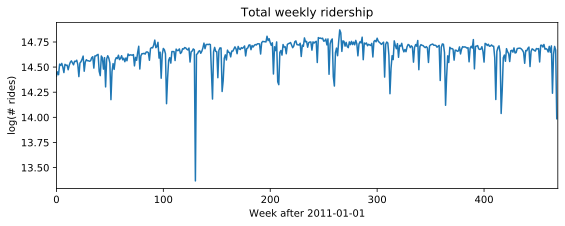

In [3]:
T, O, D = dataset["counts"].shape
data = dataset["counts"][:T // (24 * 7) * 24 * 7].reshape(T // (24 * 7), -1).sum(-1).log()
data = data.unsqueeze(-1)
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total weekly ridership")
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, len(data));

### Time-local random variables

So far we've seen the ``ForecastingModel.model()`` method and ``self.predict()``. The last piece of forecasting-specific syntax is the ``self.time_plate`` context for time-local variables. To see how this works, consider generalizing our global linear trend model above to a local linear trend model with slowly drifting slope.

In [4]:
# First we need some boilerplate to create a class and define a .model() method.
class Model(ForecastingModel):
    def model(self, zero_data, covariates):

        # The first part of the model is a probabilistic program to create a prediction.
        # We use the zero_data as a template for the shape of the prediction.
        slope = pyro.sample("slope", dist.Normal(0, 1))
        intercept = pyro.sample("intercept", dist.Normal(0, 20))
        time = torch.arange(float(zero_data.size(-2))) / 365
        prediction = (intercept + slope * time).unsqueeze(-1)
        # The prediction should have the same shape as zero_data (duration, obs_dim),
        # but may have additional sample dimensions on the left.
        assert prediction.shape[-2:] == zero_data.shape

        # The next part of the model creates a likelihood or noise distribution.
        # Again we'll be Bayesian and write this as a probabilistic program with
        # priors over parameters, and again we'll use zero_data as a noise template.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(0, 1).expand([1]).to_event(1))
        noise_dist = dist.Normal(zero_data, noise_scale)

        # The final step is to call the .predict() method.
        self.predict(noise_dist, prediction)

We can now train this model by creating a [Forecaster]() object.

In [5]:
pyro.clear_param_store()
covariates = data.new_zeros(data.size(-2), 0)  # empty covariates
forecaster = Forecaster(Model(), data, covariates)

INFO 	 step    0 loss = 1.75196
INFO 	 step  100 loss = 1.03123
INFO 	 step  200 loss = 0.189351
INFO 	 step  300 loss = -0.388629
INFO 	 step  400 loss = -0.566394
INFO 	 step  500 loss = -0.583512
INFO 	 step  600 loss = -0.564059
INFO 	 step  700 loss = -0.567759
INFO 	 step  800 loss = -0.59409
INFO 	 step  900 loss = -0.576948
INFO 	 step 1000 loss = -0.589905


In [6]:
T0 = 0
T1 = data.size(-2)
T2 = T1 + 52
covariates = data.new_zeros(data.size(-2) + 52, 0)
samples = forecaster(data, covariates, num_samples=20)
print(samples.shape)

torch.Size([20, 52, 1])


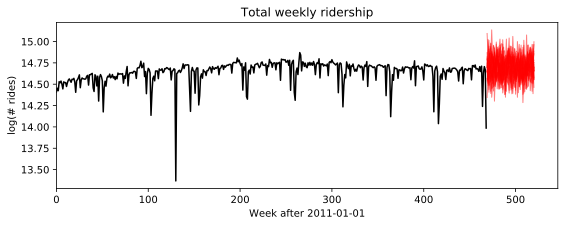

In [7]:
plt.figure(figsize=(9, 3))
plt.plot(data, 'k-')
plt.plot(torch.arange(T1, T2),
         samples.squeeze(-1).T, 'r-', lw=1, alpha=0.5)
plt.title("Total weekly ridership")
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None);

Let's start with a univariate Kalman filter model in log space, with no trend or seasonality.

In [8]:
# First we need some boilerplate to create a class and define a .model() method.
class Model(ForecastingModel):
    def model(self, zero_data, covariates):
        raise NotImplementedError("TODO")

### Regression against covariates

To demonstrate how to regress against covariates, let's add an annual seasoality component to our model.

TODO

## A bivariate seasonal model

The full dataset has all station->station ridership counts for all of 50 train stations. In this simple example we will model only the aggretate counts to and from a single station, Embarcadero.

In [9]:
i = dataset["stations"].index("EMBR")
arrivals = dataset["counts"][:, :, i].sum(-1)
departures = dataset["counts"][:, i, :].sum(-1)
data = torch.stack([arrivals, departures], dim=-1).log1p()
covariates = torch.zeros(len(data), 0)

In [10]:
class Model(ForecastingModel):
    def model(self, zero_data, covariates):
        period = 24 * 7
        duration, dim = zero_data.shape[-2:]
        assert dim == 2  # Data is bivariate: (arrivals, departures).

        # Sample global parameters.
        noise_scale = pyro.sample("noise_scale",
                                  dist.LogNormal(torch.full((dim,), -3), 1).to_event(1))
        assert noise_scale.shape[-1:] == (dim,)
        trans_timescale = pyro.sample("trans_timescale",
                                      dist.LogNormal(torch.zeros(dim), 1).to_event(1))
        assert trans_timescale.shape[-1:] == (dim,)

        trans_loc = pyro.sample("trans_loc", dist.Cauchy(0, 1 / period))
        trans_loc = trans_loc.unsqueeze(-1).expand(trans_loc.shape + (dim,))
        assert trans_loc.shape[-1:] == (dim,)

        trans_scale = pyro.sample("trans_scale",
                                  dist.LogNormal(torch.zeros(dim), 0.1).to_event(1))
        trans_corr = pyro.sample("trans_corr",
                                 dist.LKJCorrCholesky(dim, torch.ones(())))
        trans_scale_tril = trans_scale.unsqueeze(-1) * trans_corr
        assert trans_scale_tril.shape[-2:] == (dim, dim)

        obs_scale = pyro.sample("obs_scale",
                                dist.LogNormal(torch.zeros(dim), 0.1).to_event(1))
        obs_corr = pyro.sample("obs_corr",
                               dist.LKJCorrCholesky(dim, torch.ones(())))
        obs_scale_tril = obs_scale.unsqueeze(-1) * obs_corr
        assert obs_scale_tril.shape[-2:] == (dim, dim)

        with pyro.plate("season_plate", period,  dim=-1):
            season_init = pyro.sample("season_init",
                                      dist.Normal(torch.zeros(dim), 1).to_event(1))
            assert season_init.shape[-2:] == (period, dim)

        # Sample independent noise at each time step.
        with self.time_plate:
            season_noise = pyro.sample("season_noise",
                                       dist.Normal(0, noise_scale).to_event(1))
            assert season_noise.shape[-2:] == (duration, dim)

        prediction = (periodic_repeat(season_init, duration, dim=-2) +
                      periodic_cumsum(season_noise, period, dim=-2))
        assert prediction.shape[-2:] == (duration, dim)

        init_dist = dist.Normal(torch.zeros(dim), 100).to_event(1)
        trans_mat = trans_timescale.neg().exp().diag_embed()
        trans_dist = dist.MultivariateNormal(trans_loc, scale_tril=trans_scale_tril)
        obs_mat = torch.eye(dim)
        obs_dist = dist.MultivariateNormal(torch.zeros(dim), scale_tril=obs_scale_tril)
        noise_model = dist.GaussianHMM(init_dist, trans_mat, trans_dist, obs_mat, obs_dist,
                                       duration=duration)
        assert noise_model.event_shape == (duration, dim)

        self.predict(noise_model, prediction)

In [11]:
pyro.clear_param_store()

t_train = 90 * 24
forecaster = Forecaster(Model(), data[:t_train], covariates[:t_train],
                        learning_rate=0.05,
                        num_steps=501,
                        log_every=50)

INFO 	 step    0 loss = 8.62118
INFO 	 step   50 loss = 1.76442
INFO 	 step  100 loss = 1.47632
INFO 	 step  150 loss = 1.32133
INFO 	 step  200 loss = 1.29108
INFO 	 step  250 loss = 1.17904
INFO 	 step  300 loss = 1.16493
INFO 	 step  350 loss = 1.09147
INFO 	 step  400 loss = 1.06338
INFO 	 step  450 loss = 1.05855
INFO 	 step  500 loss = 1.03015


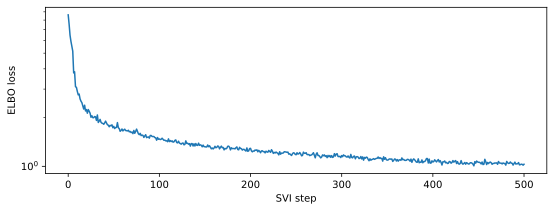

In [12]:
plt.figure(figsize=(9, 3))
plt.plot(forecaster.losses)
plt.ylabel("ELBO loss")
plt.xlabel("SVI step")
plt.yscale("log")

In [13]:
t_test = 2 * 7 * 24
samples = forecaster(data[:t_train], covariates[:t_train + t_test], num_samples=101)
samples.clamp_(min=0);
p05 = samples.kthvalue(5, dim=0).values
p50 = samples.median(dim=0).values
p95 = samples.kthvalue(95, dim=0).values

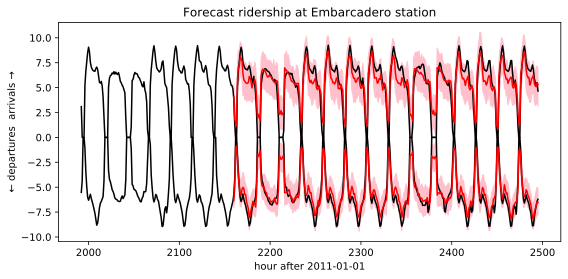

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(torch.arange(t_train - t_test // 2, t_train + t_test),
         data[t_train - t_test // 2:t_train + t_test, 0], "k-")
plt.plot(torch.arange(t_train - t_test // 2, t_train + t_test),
         -data[t_train - t_test // 2:t_train + t_test, 1], "k-")
plt.fill_between(torch.arange(t_train, t_train + t_test), p05[..., 0], p95[..., 0],
                 color="pink")
plt.fill_between(torch.arange(t_train, t_train + t_test), -p05[..., 1], -p95[..., 1],
                 color="pink")
plt.plot(torch.arange(t_train, t_train + t_test), p50[..., 0], "r-")
plt.plot(torch.arange(t_train, t_train + t_test), -p50[..., 1], "r-")
plt.ylabel("← departures  arrivals →")
plt.xlabel("hour after 2011-01-01")
plt.title("Forecast ridership at Embarcadero station")
plt.tight_layout()